In [1]:
from pyspark.sql import SparkSession, Row, functions as F, Window
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, Tokenizer, HashingTF, IDF
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import FloatType, ArrayType, IntegerType
from pyspark.sql.functions import udf, explode, array
import os

# Sedona imports for SparkSession config
try:
    from sedona.utils import SedonaKryoRegistrator, KryoSerializer
    sedona_serializer_config = True
except ImportError:
    sedona_serializer_config = False

In [2]:
# 1. Spark Session Setup
spark = (
    SparkSession.builder
    .appName("Local Spark Full Demo")
    .master("spark://localhost:7077")
    .config("spark.eventLog.gcMetrics.youngGenerationGarbageCollectors", "G1 Young Generation")
    .config("spark.eventLog.gcMetrics.oldGenerationGarbageCollectors", "G1 Old Generation")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
print("✅ Spark version:", spark.version)
print("✅ Master URL:", spark.sparkContext.master)

Picked up JAVA_TOOL_OPTIONS: 
Picked up JAVA_TOOL_OPTIONS: 
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/18 08:03:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark version: 3.5.1
✅ Master URL: spark://localhost:7077


In [3]:
# 2. DataFrame Creation and Basic Operations
# Expanded and balanced demo data for ML pipeline and cross-validation
data = [
    Row(name="Alice", age=34, income=70000, label=1),
    Row(name="Bob", age=45, income=48000, label=0),
    Row(name="Cathy", age=29, income=62000, label=1),
    Row(name="David", age=41, income=54000, label=0),
    Row(name="Eve", age=36, income=71000, label=1),
    Row(name="Frank", age=38, income=50000, label=0),
    Row(name="Grace", age=32, income=68000, label=1),
    Row(name="Heidi", age=40, income=52000, label=0),
    Row(name="Ivan", age=37, income=69000, label=1),
    Row(name="Judy", age=43, income=51000, label=0),
    Row(name="Karl", age=35, income=72000, label=1),
    Row(name="Liam", age=39, income=53000, label=0),
    Row(name="Mallory", age=33, income=66000, label=1),
    Row(name="Niaj", age=44, income=55000, label=0),
    Row(name="Olivia", age=31, income=73000, label=1),
    Row(name="Peggy", age=42, income=56000, label=0)
]
df = spark.createDataFrame(data)
print("\nOriginal DataFrame:")
df.show()


Original DataFrame:


+-------+---+------+-----+
|   name|age|income|label|
+-------+---+------+-----+
|  Alice| 34| 70000|    1|
|    Bob| 45| 48000|    0|
|  Cathy| 29| 62000|    1|
|  David| 41| 54000|    0|
|    Eve| 36| 71000|    1|
|  Frank| 38| 50000|    0|
|  Grace| 32| 68000|    1|
|  Heidi| 40| 52000|    0|
|   Ivan| 37| 69000|    1|
|   Judy| 43| 51000|    0|
|   Karl| 35| 72000|    1|
|   Liam| 39| 53000|    0|
|Mallory| 33| 66000|    1|
|   Niaj| 44| 55000|    0|
| Olivia| 31| 73000|    1|
|  Peggy| 42| 56000|    0|
+-------+---+------+-----+



In [4]:
# 3. Reading and Writing CSV Files
csv_path = "demo_people.csv"
df.write.mode("overwrite").csv(csv_path, header=True)
print(f"\nWrote DataFrame to CSV: {csv_path}")
df_csv = spark.read.csv(csv_path, header=True, inferSchema=True)
print("Read DataFrame from CSV:")
df_csv.show()


Wrote DataFrame to CSV: demo_people.csv
Read DataFrame from CSV:
+-------+---+------+-----+
|   name|age|income|label|
+-------+---+------+-----+
| Olivia| 31| 73000|    1|
|  Peggy| 42| 56000|    0|
|Mallory| 33| 66000|    1|
|   Niaj| 44| 55000|    0|
|  Grace| 32| 68000|    1|
|  Heidi| 40| 52000|    0|
|  Cathy| 29| 62000|    1|
|  David| 41| 54000|    0|
|   Karl| 35| 72000|    1|
|   Liam| 39| 53000|    0|
|   Ivan| 37| 69000|    1|
|   Judy| 43| 51000|    0|
|    Eve| 36| 71000|    1|
|  Frank| 38| 50000|    0|
|  Alice| 34| 70000|    1|
|    Bob| 45| 48000|    0|
+-------+---+------+-----+



In [5]:
# 4. DataFrame Transformations (withColumn, UDF, map)
def age_category(age):
    return "young" if age < 35 else "senior"
age_category_udf = udf(age_category)
df = df.withColumn("age_category", age_category_udf(df.age))
print("\nDataFrame with age_category column:")
df.show()


DataFrame with age_category column:


+-------+---+------+-----+------------+
|   name|age|income|label|age_category|
+-------+---+------+-----+------------+
|  Alice| 34| 70000|    1|       young|
|    Bob| 45| 48000|    0|      senior|
|  Cathy| 29| 62000|    1|       young|
|  David| 41| 54000|    0|      senior|
|    Eve| 36| 71000|    1|      senior|
|  Frank| 38| 50000|    0|      senior|
|  Grace| 32| 68000|    1|       young|
|  Heidi| 40| 52000|    0|      senior|
|   Ivan| 37| 69000|    1|      senior|
|   Judy| 43| 51000|    0|      senior|
|   Karl| 35| 72000|    1|      senior|
|   Liam| 39| 53000|    0|      senior|
|Mallory| 33| 66000|    1|       young|
|   Niaj| 44| 55000|    0|      senior|
| Olivia| 31| 73000|    1|       young|
|  Peggy| 42| 56000|    0|      senior|
+-------+---+------+-----+------------+



In [6]:
# 5. Handling Missing Data
data_with_missing = [Row(name="Eve", age=None, income=50000, label=1),
                     Row(name="Frank", age=38, income=None, label=0)]
df_missing = spark.createDataFrame(data_with_missing)
df_combined = df.unionByName(df_missing, allowMissingColumns=True)
print("\nDataFrame with missing values:")
df_combined.show()
# Update: Fill nulls in both 'age' and 'income' for ML steps
df_filled = df_combined.fillna({"age": 0, "income": 0})
print("\nFill missing ages with 0:")
df_filled.show()


DataFrame with missing values:
+-------+----+------+-----+------------+
|   name| age|income|label|age_category|
+-------+----+------+-----+------------+
|  Alice|  34| 70000|    1|       young|
|    Bob|  45| 48000|    0|      senior|
|  Cathy|  29| 62000|    1|       young|
|  David|  41| 54000|    0|      senior|
|    Eve|  36| 71000|    1|      senior|
|  Frank|  38| 50000|    0|      senior|
|  Grace|  32| 68000|    1|       young|
|  Heidi|  40| 52000|    0|      senior|
|   Ivan|  37| 69000|    1|      senior|
|   Judy|  43| 51000|    0|      senior|
|   Karl|  35| 72000|    1|      senior|
|   Liam|  39| 53000|    0|      senior|
|Mallory|  33| 66000|    1|       young|
|   Niaj|  44| 55000|    0|      senior|
| Olivia|  31| 73000|    1|       young|
|  Peggy|  42| 56000|    0|      senior|
|    Eve|NULL| 50000|    1|        NULL|
|  Frank|  38|  NULL|    0|        NULL|
+-------+----+------+-----+------------+


Fill missing ages with 0:
+-------+---+------+-----+------------

In [7]:
# 6. SQL: Temp Views, Aggregation, Group By, Join
df.createOrReplaceTempView("people")
df_filled.createOrReplaceTempView("people_filled")
print("\nSQL: People with income > 50000:")
sql_result = spark.sql("SELECT name, age FROM people WHERE income > 50000")
sql_result.show()
print("\nSQL: Group by age_category and count:")
sql_group = spark.sql("SELECT age_category, COUNT(*) as count FROM people GROUP BY age_category")
sql_group.show()
print("\nSQL: Join example:")
sql_join = spark.sql("SELECT p.name, p.age, f.income FROM people p JOIN people_filled f ON p.name = f.name")
sql_join.show()



SQL: People with income > 50000:
+-------+---+
|   name|age|
+-------+---+
|  Alice| 34|
|  Cathy| 29|
|  David| 41|
|    Eve| 36|
|  Grace| 32|
|  Heidi| 40|
|   Ivan| 37|
|   Judy| 43|
|   Karl| 35|
|   Liam| 39|
|Mallory| 33|
|   Niaj| 44|
| Olivia| 31|
|  Peggy| 42|
+-------+---+


SQL: Group by age_category and count:
+------------+-----+
|age_category|count|
+------------+-----+
|      senior|   11|
|       young|    5|
+------------+-----+


SQL: Join example:
+-------+---+------+
|   name|age|income|
+-------+---+------+
|  Alice| 34| 70000|
|    Bob| 45| 48000|
|  Cathy| 29| 62000|
|  David| 41| 54000|
|    Eve| 36| 71000|
|    Eve| 36| 50000|
|  Frank| 38| 50000|
|  Frank| 38|     0|
|  Grace| 32| 68000|
|  Heidi| 40| 52000|
|   Ivan| 37| 69000|
|   Judy| 43| 51000|
|   Karl| 35| 72000|
|   Liam| 39| 53000|
|Mallory| 33| 66000|
|   Niaj| 44| 55000|
| Olivia| 31| 73000|
|  Peggy| 42| 56000|
+-------+---+------+



In [8]:
# 7. MLlib: Feature Scaling (StandardScaler)
# Use handleInvalid='skip' for VectorAssembler
assembler = VectorAssembler(inputCols=["age", "income"], outputCol="features_raw", handleInvalid="skip")
df_ml = assembler.transform(df_filled)
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_ml)
df_scaled = scaler_model.transform(df_ml)
print("\nScaled features:")
df_scaled.select("name", "features").show(truncate=False)


Scaled features:
+-------+------------------------------------------+
|name   |features                                  |
+-------+------------------------------------------+
|Alice  |[-0.13961854577250066,0.7990042152577324] |
|Bob    |[0.966160336745707,-0.5193527399175258]   |
|Cathy  |[-0.6422453105535042,0.31960168610309303] |
|David  |[0.5640589249209043,-0.1598008430515463]  |
|Eve    |[0.06143216013990074,0.8589295314020623]  |
|Frank  |[0.26248286605230214,-0.39950210762886595]|
|Grace  |[-0.34066925168490203,0.6791535829690726] |
|Heidi  |[0.4635335719647036,-0.2796514753402061]  |
|Ivan   |[0.16195751309610146,0.7390788991134025]  |
|Judy   |[0.7651096308333056,-0.33957679148453607] |
|Karl   |[-0.03909319281629996,0.9188548475463922] |
|Liam   |[0.36300821900850283,-0.21972615919587624]|
|Mallory|[-0.24014389872870134,0.5593029506804127] |
|Niaj   |[0.8656349837895063,-0.09987552690721639] |
|Olivia |[-0.44119460464110277,0.9787801636907222] |
|Peggy  |[0.664584277877105,

In [9]:
# 8. MLlib: Train/Test Split, Model Training, Evaluation
train, test = df_scaled.randomSplit([0.7, 0.3], seed=42)
lr = LogisticRegression(featuresCol="features", labelCol="label")
model = lr.fit(train)
predictions = model.transform(test)
print("\nLogistic Regression Predictions (test set):")
predictions.select("name", "age", "income", "probability", "prediction").show(truncate=False)
evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions)
print(f"AUC on test set: {auc:.3f}")


Logistic Regression Predictions (test set):
+-----+---+------+-------------------------------------------+----------+
|name |age|income|probability                                |prediction|
+-----+---+------+-------------------------------------------+----------+
|Cathy|29 |62000 |[6.669439236875415E-20,1.0]                |1.0       |
|Eve  |36 |71000 |[7.245762563685816E-11,0.9999999999275424] |1.0       |
|Frank|38 |50000 |[0.9999389052939822,6.109470601778355E-5]  |0.0       |
|Grace|32 |68000 |[4.231174785711516E-17,1.0]                |1.0       |
|Liam |39 |53000 |[0.9999775445377301,2.2455462269865833E-5] |0.0       |
|Niaj |44 |55000 |[0.9999999999999516,4.8405723873656825E-14]|0.0       |
|Eve  |0  |50000 |[5.766639194582275E-70,1.0]                |1.0       |
+-----+---+------+-------------------------------------------+----------+

AUC on test set: 1.000


In [10]:
# 9. ADVANCED: Window Functions (Ranking, Moving Average)
print("\nWindow Functions: Ranking and Moving Average")
window_spec = Window.orderBy(F.col("income").desc())
df_ranked = df.withColumn("rank", F.rank().over(window_spec))
df_ranked = df_ranked.withColumn("moving_avg_income", F.avg("income").over(window_spec.rowsBetween(-1, 1)))
df_ranked.show()



Window Functions: Ranking and Moving Average
+-------+---+------+-----+------------+----+------------------+
|   name|age|income|label|age_category|rank| moving_avg_income|
+-------+---+------+-----+------------+----+------------------+
| Olivia| 31| 73000|    1|       young|   1|           72500.0|
|   Karl| 35| 72000|    1|      senior|   2|           72000.0|
|    Eve| 36| 71000|    1|      senior|   3|           71000.0|
|  Alice| 34| 70000|    1|       young|   4|           70000.0|
|   Ivan| 37| 69000|    1|      senior|   5|           69000.0|
|  Grace| 32| 68000|    1|       young|   6| 67666.66666666667|
|Mallory| 33| 66000|    1|       young|   7|65333.333333333336|
|  Cathy| 29| 62000|    1|       young|   8|61333.333333333336|
|  Peggy| 42| 56000|    0|      senior|   9|57666.666666666664|
|   Niaj| 44| 55000|    0|      senior|  10|           55000.0|
|  David| 41| 54000|    0|      senior|  11|           54000.0|
|   Liam| 39| 53000|    0|      senior|  12|           530

In [11]:
# 10. ADVANCED: Explode and Array Operations
print("\nExplode and Array Operations")
df_array = df.withColumn("scores", array(F.lit(1), F.lit(2), F.lit(3)))
df_exploded = df_array.select("name", explode("scores").alias("score"))
df_exploded.show()



Explode and Array Operations
+-----+-----+
| name|score|
+-----+-----+
|Alice|    1|
|Alice|    2|
|Alice|    3|
|  Bob|    1|
|  Bob|    2|
|  Bob|    3|
|Cathy|    1|
|Cathy|    2|
|Cathy|    3|
|David|    1|
|David|    2|
|David|    3|
|  Eve|    1|
|  Eve|    2|
|  Eve|    3|
|Frank|    1|
|Frank|    2|
|Frank|    3|
|Grace|    1|
|Grace|    2|
+-----+-----+
only showing top 20 rows



In [12]:
# 11. ADVANCED: Pivot Table
print("\nPivot Table Example")
df_pivot = df.groupBy("age_category").pivot("label").agg(F.avg("income"))
df_pivot.show()


Pivot Table Example
+------------+-------+-----------------+
|age_category|      0|                1|
+------------+-------+-----------------+
|      senior|52375.0|70666.66666666667|
|       young|   NULL|          67800.0|
+------------+-------+-----------------+



In [13]:
# 12. ADVANCED: Broadcast Join
print("\nBroadcast Join Example")
small_df = spark.createDataFrame([Row(name="Alice", country="US"), Row(name="Bob", country="UK")])
broadcast_joined = df.join(F.broadcast(small_df), on="name", how="left")
broadcast_joined.show()


Broadcast Join Example
+-------+---+------+-----+------------+-------+
|   name|age|income|label|age_category|country|
+-------+---+------+-----+------------+-------+
|  Alice| 34| 70000|    1|       young|     US|
|    Bob| 45| 48000|    0|      senior|     UK|
|  Cathy| 29| 62000|    1|       young|   NULL|
|  David| 41| 54000|    0|      senior|   NULL|
|    Eve| 36| 71000|    1|      senior|   NULL|
|  Frank| 38| 50000|    0|      senior|   NULL|
|  Grace| 32| 68000|    1|       young|   NULL|
|  Heidi| 40| 52000|    0|      senior|   NULL|
|   Ivan| 37| 69000|    1|      senior|   NULL|
|   Judy| 43| 51000|    0|      senior|   NULL|
|   Karl| 35| 72000|    1|      senior|   NULL|
|   Liam| 39| 53000|    0|      senior|   NULL|
|Mallory| 33| 66000|    1|       young|   NULL|
|   Niaj| 44| 55000|    0|      senior|   NULL|
| Olivia| 31| 73000|    1|       young|   NULL|
|  Peggy| 42| 56000|    0|      senior|   NULL|
+-------+---+------+-----+------------+-------+



In [14]:
# 13. ADVANCED: Linear Regression
print("\nLinear Regression Example")
lr_reg = LinearRegression(featuresCol="features", labelCol="income")
lr_model = lr_reg.fit(df_scaled)
lr_predictions = lr_model.transform(df_scaled)
lr_predictions.select("name", "age", "income", "prediction").show()
reg_evaluator = RegressionEvaluator(labelCol="income", predictionCol="prediction", metricName="rmse")
rmse = reg_evaluator.evaluate(lr_predictions)
print(f"Linear Regression RMSE: {rmse:.2f}")


Linear Regression Example
+-------+---+------+-----------------+
|   name|age|income|       prediction|
+-------+---+------+-----------------+
|  Alice| 34| 70000|          70000.0|
|    Bob| 45| 48000|          48000.0|
|  Cathy| 29| 62000|          62000.0|
|  David| 41| 54000|          54000.0|
|    Eve| 36| 71000|          71000.0|
|  Frank| 38| 50000|          50000.0|
|  Grace| 32| 68000|          68000.0|
|  Heidi| 40| 52000|          52000.0|
|   Ivan| 37| 69000|          69000.0|
|   Judy| 43| 51000|          51000.0|
|   Karl| 35| 72000|          72000.0|
|   Liam| 39| 53000|          53000.0|
|Mallory| 33| 66000|          66000.0|
|   Niaj| 44| 55000|          55000.0|
| Olivia| 31| 73000|          73000.0|
|  Peggy| 42| 56000|          56000.0|
|    Eve|  0| 50000|50000.00000000001|
|  Frank| 38|     0|              0.0|
+-------+---+------+-----------------+

Linear Regression RMSE: 0.00


In [15]:
# 14. ADVANCED: KMeans Clustering
print("\nKMeans Clustering Example")
kmeans = KMeans(featuresCol="features", k=2, seed=1)
kmeans_model = kmeans.fit(df_scaled)
kmeans_predictions = kmeans_model.transform(df_scaled)
kmeans_predictions.select("name", "age", "income", "prediction").show()


KMeans Clustering Example
+-------+---+------+----------+
|   name|age|income|prediction|
+-------+---+------+----------+
|  Alice| 34| 70000|         1|
|    Bob| 45| 48000|         0|
|  Cathy| 29| 62000|         1|
|  David| 41| 54000|         0|
|    Eve| 36| 71000|         1|
|  Frank| 38| 50000|         0|
|  Grace| 32| 68000|         1|
|  Heidi| 40| 52000|         0|
|   Ivan| 37| 69000|         1|
|   Judy| 43| 51000|         0|
|   Karl| 35| 72000|         1|
|   Liam| 39| 53000|         0|
|Mallory| 33| 66000|         1|
|   Niaj| 44| 55000|         0|
| Olivia| 31| 73000|         1|
|  Peggy| 42| 56000|         0|
|    Eve|  0| 50000|         1|
|  Frank| 38|     0|         0|
+-------+---+------+----------+



In [16]:
# 15. ADVANCED: ML Pipeline and Cross-Validation
print("\nML Pipeline and Cross-Validation Example")
indexer = StringIndexer(inputCol="age_category", outputCol="age_cat_index")
assembler = VectorAssembler(inputCols=["age", "income"], outputCol="features_raw", handleInvalid="skip")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
lr = LogisticRegression(featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[indexer, assembler, scaler, lr])
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="label"),
                          numFolds=2)
cv_model = crossval.fit(df_filled)
cv_predictions = cv_model.transform(df_filled)
print("Cross-validated predictions:")
cv_predictions.select("name", "age", "income", "probability", "prediction").show(truncate=False)




ML Pipeline and Cross-Validation Example
Cross-validated predictions:
+-------+---+------+-----------------------------------------+----------+
|name   |age|income|probability                              |prediction|
+-------+---+------+-----------------------------------------+----------+
|Alice  |34 |70000 |[0.06672389830440972,0.9332761016955903] |1.0       |
|Bob    |45 |48000 |[0.9870154494042499,0.0129845505957501]  |0.0       |
|Cathy  |29 |62000 |[0.09021466482879903,0.909785335171201]  |1.0       |
|David  |41 |54000 |[0.8988980579963376,0.1011019420036624]  |0.0       |
|Eve    |36 |71000 |[0.08771698437571739,0.9122830156242826] |1.0       |
|Frank  |38 |50000 |[0.9025588378175352,0.09744116218246479] |0.0       |
|Grace  |32 |68000 |[0.06063788203758433,0.9393621179624156] |1.0       |
|Heidi  |40 |52000 |[0.9111799894466136,0.0888200105533864]  |0.0       |
|Ivan   |37 |69000 |[0.15338648542220926,0.8466135145777908] |1.0       |
|Judy   |43 |51000 |[0.9629589090270195,0

In [17]:
# 16. ADVANCED: Reading JSON and Parquet
print("\nReading and Writing JSON/Parquet")
json_path = "demo_people.json"
parquet_path = "demo_people.parquet"
df.write.mode("overwrite").json(json_path)
df.write.mode("overwrite").parquet(parquet_path)
df_json = spark.read.json(json_path)
df_parquet = spark.read.parquet(parquet_path)
print("Read from JSON:")
df_json.show()
print("Read from Parquet:")
df_parquet.show()


Reading and Writing JSON/Parquet


Read from JSON:
+---+------------+------+-----+-------+
|age|age_category|income|label|   name|
+---+------------+------+-----+-------+
| 33|       young| 66000|    1|Mallory|
| 44|      senior| 55000|    0|   Niaj|
| 31|       young| 73000|    1| Olivia|
| 42|      senior| 56000|    0|  Peggy|
| 29|       young| 62000|    1|  Cathy|
| 41|      senior| 54000|    0|  David|
| 32|       young| 68000|    1|  Grace|
| 40|      senior| 52000|    0|  Heidi|
| 37|      senior| 69000|    1|   Ivan|
| 43|      senior| 51000|    0|   Judy|
| 36|      senior| 71000|    1|    Eve|
| 38|      senior| 50000|    0|  Frank|
| 35|      senior| 72000|    1|   Karl|
| 39|      senior| 53000|    0|   Liam|
| 34|       young| 70000|    1|  Alice|
| 45|      senior| 48000|    0|    Bob|
+---+------------+------+-----+-------+

Read from Parquet:
+-------+---+------+-----+------------+
|   name|age|income|label|age_category|
+-------+---+------+-----+------------+
|   Ivan| 37| 69000|    1|      senior|
|   

In [18]:

# 17. ADVANCED: Saving and Loading Models
print("\nSaving and Loading Models")
model_path = "demo_lr_model"
lr_model.write().overwrite().save(model_path)
loaded_lr_model = LinearRegressionModel.load(model_path)
print("Loaded model coefficients:", loaded_lr_model.coefficients)



Saving and Loading Models
Loaded model coefficients: [-1.6210930689248104e-12,16687.438036897518]


In [19]:
# 18. ADVANCED: RDD Broadcast and Accumulator
print("\nRDD Broadcast and Accumulator Example")
rdd = spark.sparkContext.parallelize([1, 2, 3, 4, 5])
broadcast_var = spark.sparkContext.broadcast(10)
accum = spark.sparkContext.accumulator(0)
def add_broadcast(x):
    global accum
    accum += x
    return x + broadcast_var.value
rdd_result = rdd.map(add_broadcast).collect()
print("RDD map with broadcast result:", rdd_result)
print("Accumulator value:", accum.value)


RDD Broadcast and Accumulator Example
RDD map with broadcast result: [11, 12, 13, 14, 15]
Accumulator value: 15


In [20]:
# 20. SPECIALIZED: Time Series - Lag, Lead, and Rolling Window
print("\nTime Series: Lag, Lead, and Rolling Window")
ts_data = [
    ("2024-07-01", 100),
    ("2024-07-02", 110),
    ("2024-07-03", 105),
    ("2024-07-04", 120),
    ("2024-07-05", 115)
]
df_ts = spark.createDataFrame(ts_data, ["date", "value"])
window_spec = Window.orderBy("date")
df_ts = df_ts.withColumn("lag_1", F.lag("value", 1).over(window_spec))
df_ts = df_ts.withColumn("lead_1", F.lead("value", 1).over(window_spec))
df_ts = df_ts.withColumn("rolling_avg_3", F.avg("value").over(window_spec.rowsBetween(-2, 0)))
df_ts.show()


Time Series: Lag, Lead, and Rolling Window
+----------+-----+-----+------+------------------+
|      date|value|lag_1|lead_1|     rolling_avg_3|
+----------+-----+-----+------+------------------+
|2024-07-01|  100| NULL|   110|             100.0|
|2024-07-02|  110|  100|   105|             105.0|
|2024-07-03|  105|  110|   120|             105.0|
|2024-07-04|  120|  105|   115|111.66666666666667|
|2024-07-05|  115|  120|  NULL|113.33333333333333|
+----------+-----+-----+------+------------------+



In [21]:
# 21. SPECIALIZED: Text Processing - Tokenization and TF-IDF
print("\nText Processing: Tokenization and TF-IDF")
text_data = [
    (0, "Spark is great for big data processing"),
    (1, "Big data requires scalable solutions"),
    (2, "Spark and Hadoop are popular tools")
]
df_text = spark.createDataFrame(text_data, ["id", "text"])
tokenizer = Tokenizer(inputCol="text", outputCol="words")
words_data = tokenizer.transform(df_text)
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurized_data = hashing_tf.transform(words_data)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)
rescaled_data.select("id", "features").show(truncate=False)


Text Processing: Tokenization and TF-IDF


+---+---------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                   |
+---+---------------------------------------------------------------------------------------------------------------------------+
|0  |(20,[4,6,8,9,10,15],[0.6931471805599453,0.5753641449035617,0.0,0.6931471805599453,0.28768207245178085,0.28768207245178085])|
|1  |(20,[8,10,15,18],[0.0,0.5753641449035617,0.28768207245178085,0.6931471805599453])                                          |
|2  |(20,[1,3,5,6,8,11],[0.6931471805599453,0.6931471805599453,0.6931471805599453,0.28768207245178085,0.0,0.6931471805599453])  |
+---+---------------------------------------------------------------------------------------------------------------------------+



In [22]:
# # 22. SPECIALIZED: Graph Analytics - PageRank with GraphFrames
# print("\nGraph Analytics: PageRank with GraphFrames")
# print("NOTE: Requires 'graphframes' package. Install with: pip install graphframes")
# try:
#     from graphframes import GraphFrame
#     vertices = spark.createDataFrame([
#         ("a", "Alice"), ("b", "Bob"), ("c", "Charlie")
#     ], ["id", "name"])
#     edges = spark.createDataFrame([
#         ("a", "b"), ("b", "c"), ("c", "a")
#     ], ["src", "dst"])
#     g = GraphFrame(vertices, edges)
#     results = g.pageRank(resetProbability=0.15, maxIter=10)
#     results.vertices.select("id", "pagerank").show()
# except ImportError:
#     print("GraphFrames not installed. Skipping this section.")


In [23]:
# 23. SPECIALIZED: Integration with Pandas
import pandas as pd
print("\nIntegration with Pandas")
pdf = pd.DataFrame({"x": [1, 2, 3], "y": [4, 5, 6]})
df_from_pandas = spark.createDataFrame(pdf)
df_from_pandas.show()
# Convert Spark DataFrame to Pandas
pandas_df = df_from_pandas.toPandas()
print(pandas_df)


Integration with Pandas
+---+---+
|  x|  y|
+---+---+
|  1|  4|
|  2|  5|
|  3|  6|
+---+---+

   x  y
0  1  4
1  2  5
2  3  6


In [24]:
# # 24. SPECIALIZED: External Data Source - Read from SQL Database (JDBC Example)
# print("\nRead from SQL Database (JDBC Example)")
# print("NOTE: For SQLite, download the JDBC driver from https://github.com/xerial/sqlite-jdbc/releases and add it to Spark with --jars or PYSPARK_SUBMIT_ARGS.")
# print("Example:")
# print("  spark-submit --jars /path/to/sqlite-jdbc-3.45.1.0.jar ...")
# print("  OR set PYSPARK_SUBMIT_ARGS=\"--jars /path/to/sqlite-jdbc-3.45.1.0.jar pyspark-shell\"")
# jdbc_url = "jdbc:sqlite:/path/to/your/database.db"
# properties = {"driver": "org.sqlite.JDBC"}
# # Example usage (uncomment and configure):
# # df_sql = spark.read.jdbc(jdbc_url, "your_table", properties=properties)
# # df_sql.show()
# print("Uncomment and configure the code above to use JDBC with your database. For other databases, use the appropriate JDBC URL and driver.")



Read from SQL Database (JDBC Example)
NOTE: For SQLite, download the JDBC driver from https://github.com/xerial/sqlite-jdbc/releases and add it to Spark with --jars or PYSPARK_SUBMIT_ARGS.
Example:
  spark-submit --jars /path/to/sqlite-jdbc-3.45.1.0.jar ...
  OR set PYSPARK_SUBMIT_ARGS="--jars /path/to/sqlite-jdbc-3.45.1.0.jar pyspark-shell"
Uncomment and configure the code above to use JDBC with your database. For other databases, use the appropriate JDBC URL and driver.


In [37]:
# # 25. PURE PYTHON GEOSPATIAL: Sedona Geometry Objects
# print("\nPure Python Geospatial: Sedona Geometry Objects")
# try:
#     from sedona.core.geom.envelope import Envelope
#     from sedona.core.geom.point import Point
#     from shapely import wkt
#     # Create points
#     p1 = Point(1, 1)
#     p2 = Point(2, 2)
#     # Envelope (bounding box)
#     env = Envelope(0, 3, 0, 3)
#     print("Envelope contains p1:", env.contains(p1))
#     print("Envelope contains p2:", env.contains(p2))
#     # Buffer
#     buffered = p1.buffer(1.0)
#     print("Buffered geometry:", buffered)
# except ImportError:
#     print("Sedona not installed or only PyPI version available. Skipping JVM-dependent geospatial features.")

In [26]:
# 26. PYSPARK: Create DataFrame from Python Geometries (WKT)
print("\nPySpark: Create DataFrame from Python Geometries (WKT)")
from pyspark.sql import Row
# Example: create a DataFrame from WKT strings
wkt_points = ["POINT(1 1)", "POINT(2 2)", "POINT(3 3)"]
df_wkt = spark.createDataFrame([Row(id=i, wkt=w) for i, w in enumerate(wkt_points, 1)])
df_wkt.show()



PySpark: Create DataFrame from Python Geometries (WKT)
+---+----------+
| id|       wkt|
+---+----------+
|  1|POINT(1 1)|
|  2|POINT(2 2)|
|  3|POINT(3 3)|
+---+----------+



In [27]:
# 27. ADVANCED UDFs: Standard PySpark UDFs and Scala/Java UDF mention
print("\nAdvanced UDFs: Standard PySpark UDFs and Scala/Java UDFs")
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def multiply_by_two(x):
    return x * 2

multiply_by_two_udf = udf(multiply_by_two, IntegerType())
df_udf = spark.createDataFrame([(1,), (2,), (3,)], ["num"])
df_udf = df_udf.withColumn("doubled", multiply_by_two_udf(df_udf.num))
df_udf.show()

print("\nNote: You can also register UDFs written in Scala/Java and use them from PySpark. See Spark docs for details.")





Advanced UDFs: Standard PySpark UDFs and Scala/Java UDFs
+---+-------+
|num|doubled|
+---+-------+
|  1|      2|
|  2|      4|
|  3|      6|
+---+-------+


Note: You can also register UDFs written in Scala/Java and use them from PySpark. See Spark docs for details.


In [28]:
# # 28. GEOSPATIAL JOINS: Points within Polygons (Apache Sedona)
# print("\nGeospatial Joins: Points within Polygons (Apache Sedona)")
# print("NOTE: Requires 'apache-sedona' and Sedona Spark JARs. Install with: pip install apache-sedona")
# try:
#     from sedona.register import SedonaRegistrator
#     from sedona.sql import functions as S
#     SedonaRegistrator.registerAll(spark)
#     # Points DataFrame
#     points_data = [(1, "POINT(1 1)"), (2, "POINT(2 2)"), (3, "POINT(3 3)"), (4, "POINT(5 5)")]
#     df_points = spark.createDataFrame(points_data, ["pid", "wkt_point"])
#     df_points = df_points.withColumn("geom_point", S.ST_GeomFromWKT(df_points.wkt_point))
#     # Polygons DataFrame
#     polygons_data = [
#         (10, "POLYGON((0 0, 0 4, 4 4, 4 0, 0 0))"),
#         (20, "POLYGON((4 4, 4 6, 6 6, 6 4, 4 4))")
#     ]
#     df_polygons = spark.createDataFrame(polygons_data, ["gid", "wkt_poly"])
#     df_polygons = df_polygons.withColumn("geom_poly", S.ST_GeomFromWKT(df_polygons.wkt_poly))
#     # Geospatial join: which points are in which polygons?
#     joined = df_points.join(df_polygons, S.ST_Contains(df_polygons.geom_poly, df_points.geom_point))
#     print("Points within polygons:")
#     joined.select("pid", "wkt_point", "gid", "wkt_poly").show()
# except ImportError:
#     print("Sedona not installed. Skipping geospatial join section.")


Geospatial Joins: Points within Polygons (Apache Sedona)
NOTE: Requires 'apache-sedona' and Sedona Spark JARs. Install with: pip install apache-sedona
Sedona not installed. Skipping geospatial join section.


In [29]:

# # 29. GEOSPATIAL: Distance Joins (Apache Sedona)
# print("\nGeospatial: Distance Joins (Apache Sedona)")
# print("NOTE: Requires 'apache-sedona' and Sedona Spark JARs. Install with: pip install apache-sedona")
# try:
#     from sedona.register import SedonaRegistrator
#     from sedona.sql import functions as S
#     SedonaRegistrator.registerAll(spark)
#     # Points DataFrame
#     points_data = [(1, "POINT(1 1)"), (2, "POINT(2 2)"), (3, "POINT(3 3)"), (4, "POINT(5 5)")]
#     df_points = spark.createDataFrame(points_data, ["pid", "wkt_point"])
#     df_points = df_points.withColumn("geom_point", S.ST_GeomFromWKT(df_points.wkt_point))
#     # Centers DataFrame
#     centers_data = [(100, "POINT(2 2)"), (200, "POINT(5 5)")]
#     df_centers = spark.createDataFrame(centers_data, ["cid", "wkt_center"])
#     df_centers = df_centers.withColumn("geom_center", S.ST_GeomFromWKT(df_centers.wkt_center))
#     # Distance join: points within distance 2.5 of centers
#     joined_dist = df_points.crossJoin(df_centers).where(S.ST_Distance(df_points.geom_point, df_centers.geom_center) <= 2.5)
#     print("Points within distance 2.5 of centers:")
#     joined_dist.select("pid", "wkt_point", "cid", "wkt_center").show()
# except ImportError:
#     print("Sedona not installed. Skipping distance join section.")


Geospatial: Distance Joins (Apache Sedona)
NOTE: Requires 'apache-sedona' and Sedona Spark JARs. Install with: pip install apache-sedona
Sedona not installed. Skipping distance join section.


In [30]:
# # 30. GEOSPATIAL: Spatial Indexing (Apache Sedona)
# print("\nGeospatial: Spatial Indexing (Apache Sedona)")
# print("NOTE: Requires 'apache-sedona' and Sedona Spark JARs. Install with: pip install apache-sedona")
# try:
#     from sedona.register import SedonaRegistrator
#     from sedona.sql import functions as S
#     SedonaRegistrator.registerAll(spark)
#     # Points DataFrame
#     points_data = [(1, "POINT(1 1)"), (2, "POINT(2 2)"), (3, "POINT(3 3)"), (4, "POINT(5 5)")]
#     df_points = spark.createDataFrame(points_data, ["pid", "wkt_point"])
#     df_points = df_points.withColumn("geom_point", S.ST_GeomFromWKT(df_points.wkt_point))
#     # Build spatial index (R-Tree) on points
#     df_points.createOrReplaceTempView("points_indexed")
#     spark.sql("CACHE TABLE points_indexed")
#     print("Spatial index created and table cached.")
#     # Query using index (e.g., bounding box)
#     bbox = "POLYGON((0 0, 0 3, 3 3, 3 0, 0 0))"
#     result = spark.sql(f"""
#         SELECT * FROM points_indexed
#         WHERE ST_Contains(ST_GeomFromText('{bbox}'), geom_point)
#     """)
#     print("Points within bounding box:")
#     result.show()
# except ImportError:
#     print("Sedona not installed. Skipping spatial indexing section.")



Geospatial: Spatial Indexing (Apache Sedona)
NOTE: Requires 'apache-sedona' and Sedona Spark JARs. Install with: pip install apache-sedona
Sedona not installed. Skipping spatial indexing section.



Geospatial Visualization (matplotlib, geopandas)
NOTE: Requires 'geopandas' and 'matplotlib'. Install with: pip install geopandas matplotlib


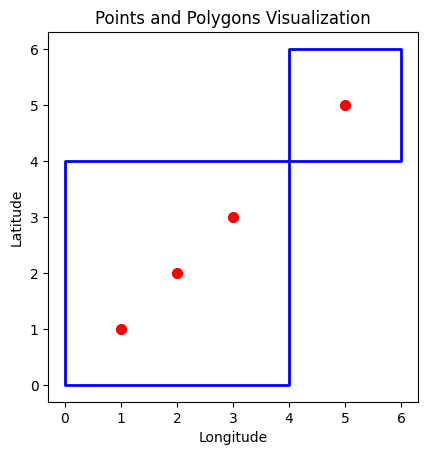

In [31]:
# 31. GEOSPATIAL: Visualization (matplotlib, geopandas)
print("\nGeospatial Visualization (matplotlib, geopandas)")
print("NOTE: Requires 'geopandas' and 'matplotlib'. Install with: pip install geopandas matplotlib")
try:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    from shapely import wkt
    # Use points and polygons from previous examples
    points_data = [(1, "POINT(1 1)"), (2, "POINT(2 2)"), (3, "POINT(3 3)"), (4, "POINT(5 5)")]
    polygons_data = [
        (10, "POLYGON((0 0, 0 4, 4 4, 4 0, 0 0))"),
        (20, "POLYGON((4 4, 4 6, 6 6, 6 4, 4 4))")
    ]
    gdf_points = gpd.GeoDataFrame(
        [(pid, wkt.loads(wkt_point)) for pid, wkt_point in points_data],
        columns=["pid", "geometry"]
    )
    gdf_polygons = gpd.GeoDataFrame(
        [(gid, wkt.loads(wkt_poly)) for gid, wkt_poly in polygons_data],
        columns=["gid", "geometry"]
    )
    ax = gdf_polygons.plot(facecolor='none', edgecolor='blue', linewidth=2)
    gdf_points.plot(ax=ax, color='red', markersize=50)
    plt.title("Points and Polygons Visualization")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
except ImportError:
    print("geopandas or matplotlib not installed. Skipping visualization section.")


In [32]:
# # 32. GEOSPATIAL: Aggregations (Count Points per Polygon)
# print("\nGeospatial Aggregations: Count Points per Polygon (Apache Sedona)")
# print("NOTE: Requires 'apache-sedona' and Sedona Spark JARs. Install with: pip install apache-sedona")
# try:
#     from sedona.register import SedonaRegistrator
#     from sedona.sql import functions as S
#     SedonaRegistrator.registerAll(spark)
#     # Points DataFrame
#     points_data = [(1, "POINT(1 1)"), (2, "POINT(2 2)"), (3, "POINT(3 3)"), (4, "POINT(5 5)")]
#     df_points = spark.createDataFrame(points_data, ["pid", "wkt_point"])
#     df_points = df_points.withColumn("geom_point", S.ST_GeomFromWKT(df_points.wkt_point))
#     # Polygons DataFrame
#     polygons_data = [
#         (10, "POLYGON((0 0, 0 4, 4 4, 4 0, 0 0))"),
#         (20, "POLYGON((4 4, 4 6, 6 6, 6 4, 4 4))")
#     ]
#     df_polygons = spark.createDataFrame(polygons_data, ["gid", "wkt_poly"])
#     df_polygons = df_polygons.withColumn("geom_poly", S.ST_GeomFromWKT(df_polygons.wkt_poly))
#     # Join and aggregate: count points per polygon
#     joined = df_points.join(df_polygons, S.ST_Contains(df_polygons.geom_poly, df_points.geom_point), how="inner")
#     agg = joined.groupBy("gid").count()
#     print("Count of points per polygon:")
#     agg.show()
# except ImportError:
#     print("Sedona not installed. Skipping geospatial aggregation section.")


Geospatial Aggregations: Count Points per Polygon (Apache Sedona)
NOTE: Requires 'apache-sedona' and Sedona Spark JARs. Install with: pip install apache-sedona
Sedona not installed. Skipping geospatial aggregation section.



Geospatial Heatmap Visualization (matplotlib, geopandas)
NOTE: Requires 'geopandas' and 'matplotlib'. Install with: pip install geopandas matplotlib


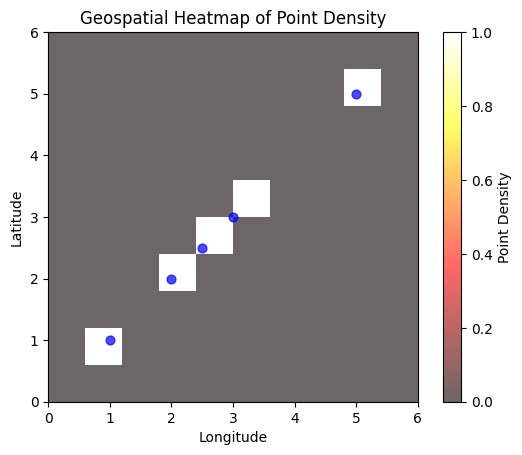

In [33]:
# # 33. GEOSPATIAL: Heatmap Visualization (matplotlib, geopandas)
# print("\nGeospatial Heatmap Visualization (matplotlib, geopandas)")
# print("NOTE: Requires 'geopandas' and 'matplotlib'. Install with: pip install geopandas matplotlib")
# try:
#     import geopandas as gpd
#     import matplotlib.pyplot as plt
#     from shapely import wkt
#     import numpy as np
#     # Use points from previous examples
#     points_data = [(1, "POINT(1 1)"), (2, "POINT(2 2)"), (3, "POINT(3 3)"), (4, "POINT(5 5)"), (5, "POINT(2.5 2.5)")]
#     gdf_points = gpd.GeoDataFrame(
#         [(pid, wkt.loads(wkt_point)) for pid, wkt_point in points_data],
#         columns=["pid", "geometry"]
#     )
#     # Create a 2D histogram (heatmap) of point density
#     x = gdf_points.geometry.x
#     y = gdf_points.geometry.y
#     heatmap, xedges, yedges = np.histogram2d(x, y, bins=(10, 10), range=[[0, 6], [0, 6]])
#     extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#     plt.clf()
#     plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', alpha=0.6)
#     plt.colorbar(label='Point Density')
#     gdf_points.plot(ax=plt.gca(), color='blue', markersize=40, alpha=0.7)
#     plt.title("Geospatial Heatmap of Point Density")
#     plt.xlabel("Longitude")
#     plt.ylabel("Latitude")
#     plt.show()
# except ImportError:
#     print("geopandas, matplotlib, or numpy not installed. Skipping heatmap section.")

In [34]:

# # 34. INTEGRATION: Read GraphX PageRank Output from Scala
# print("\nIntegration: Read GraphX PageRank Output from Scala (Parquet)")
# print("NOTE: This requires running the Scala GraphX job to produce 'graphx_pagerank_output' first.")
# try:
#     df_graphx = spark.read.parquet("graphx_pagerank_output")
#     df_graphx.show()
# except Exception as e:
#     print("Could not read GraphX output. Make sure the Scala job has run and output exists.")
#     print(e)


Integration: Read GraphX PageRank Output from Scala (Parquet)
NOTE: This requires running the Scala GraphX job to produce 'graphx_pagerank_output' first.
Could not read GraphX output. Make sure the Scala job has run and output exists.
[PATH_NOT_FOUND] Path does not exist: file:/Users/admin/work_database_cleanup/graphx_pagerank_output.


In [35]:
# 19. Clean up
spark.stop()
print("\nSpark session stopped.")

# Clean up files
try:
    import shutil
    shutil.rmtree(csv_path)
    shutil.rmtree(json_path)
    shutil.rmtree(parquet_path)
    shutil.rmtree(model_path)
except Exception:
    pass


Spark session stopped.
